In [48]:
import pandas as pd
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm  # Import tqdm
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot  as plt

import seaborn as sns

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
# creating a new feautre as label which we will as a target in our machine learning model


#0 - negative
#2 - positive
#1 - neutral

df['label'] = df['Rating'].apply(lambda x: 1 if x == 3 else (0 if x==1 or x==2 else (2 if x == 4 or x==5 else None)))




In [4]:
#text preprocessing

# 1) Removal of punctuation
# 2) Removal of stopwords
# 3) Tokenization
# 4) Lemmatization

In [5]:
# download nltk packages

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Affan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Affan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Affan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Affan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:

`

In [9]:
df["label"].value_counts()

2    15093
0     3214
1     2184
Name: label, dtype: int64

As we can see we have arounf 15000 positive reviews and negative and neutral reviews are less than 3500 reviews

This will lead to biased decision so we are oversampling the negative and neutral reviews

In [13]:
df_positive = df[df['label'] == 2]
df_negative = df[df['label'] == 0]
df_neutral = df[df['label'] == 1]

# Determine the size of the majority class (positive)
n_samples_positive = len(df_positive)

df_negative_oversampled = resample(df_negative,
                                   replace=True,     # sample with replacement
                                   n_samples=n_samples_positive,  # match majority class size
                                   random_state=42)  # for reproducibility

# Oversample the neutral class
df_neutral_oversampled = resample(df_neutral,
                                  replace=True,
                                  n_samples=n_samples_positive,
                                  random_state=42)

# Combine the oversampled minority classes with the majority class
df_oversampled = pd.concat([df_positive, df_negative_oversampled, df_neutral_oversampled])


In [15]:
# Now df_oversampled contains your balanced dataset
print("Original class distribution:")
print(df['label'].value_counts())
print("\nOversampled class distribution:")
print(df_oversampled['label'].value_counts())


Original class distribution:
2    15093
0     3214
1     2184
Name: label, dtype: int64

Oversampled class distribution:
2    15093
0    15093
1    15093
Name: label, dtype: int64


In [25]:
# storing positive data seperately

positive_data = df_positive['Review'].tolist()
positive_data = ''.join([ word for word in positive_data])

positive_data
# storing negative data seperately

negative_data = df_negative['Review'].tolist()
negative_data = ''.join([ word for word in negative_data])

# storing neutral data seperately

neutral_data = df_neutral['Review'].tolist()
neutral_data = ''.join([ word for word in neutral_data])

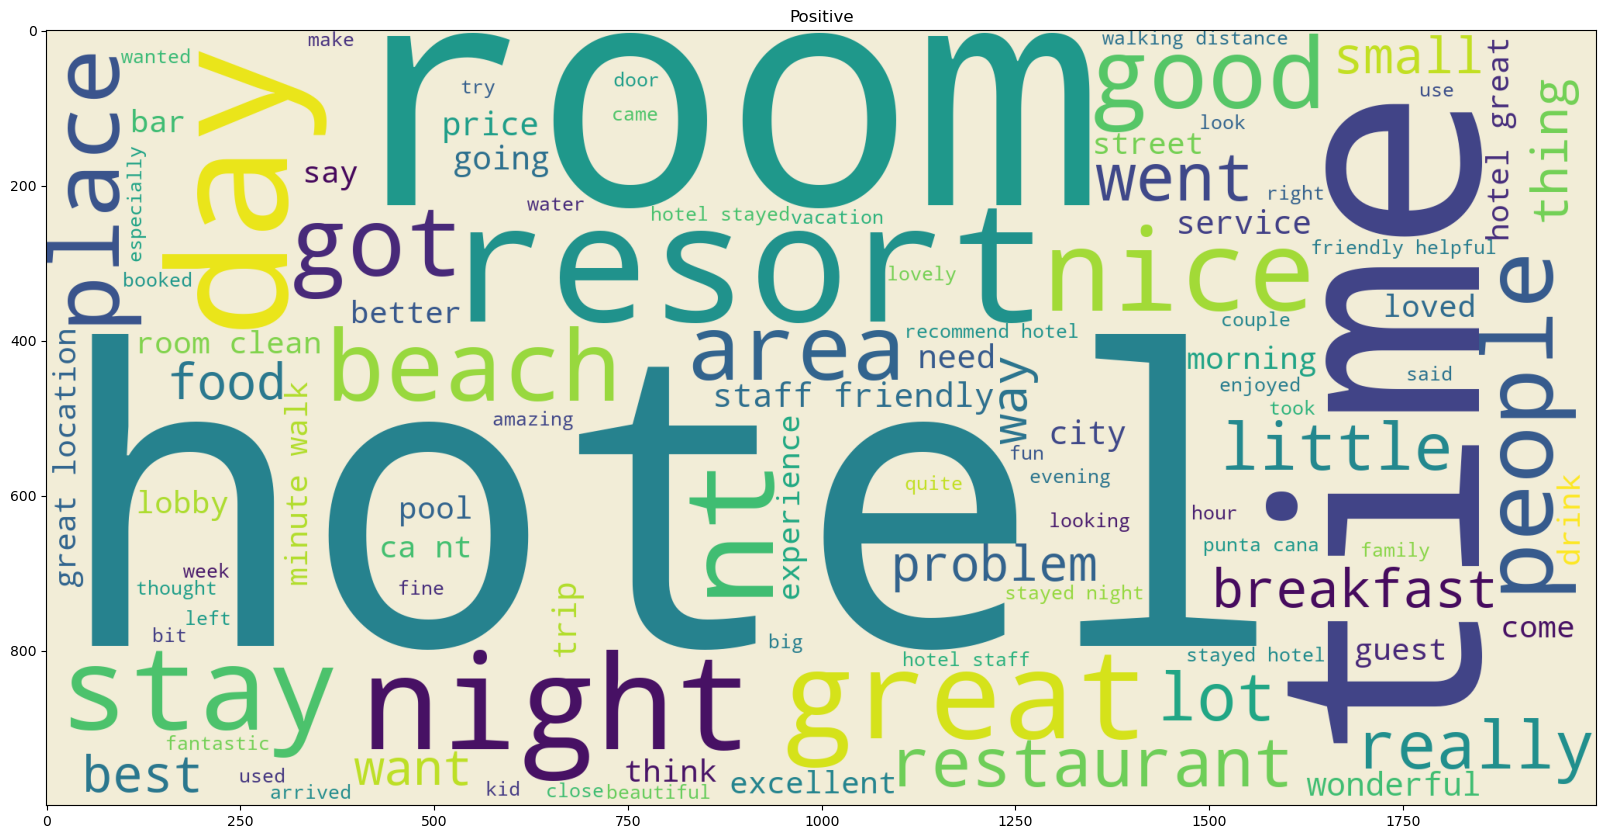

In [28]:
# Word cloud of positive, negative and neutral data

WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(positive_data)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

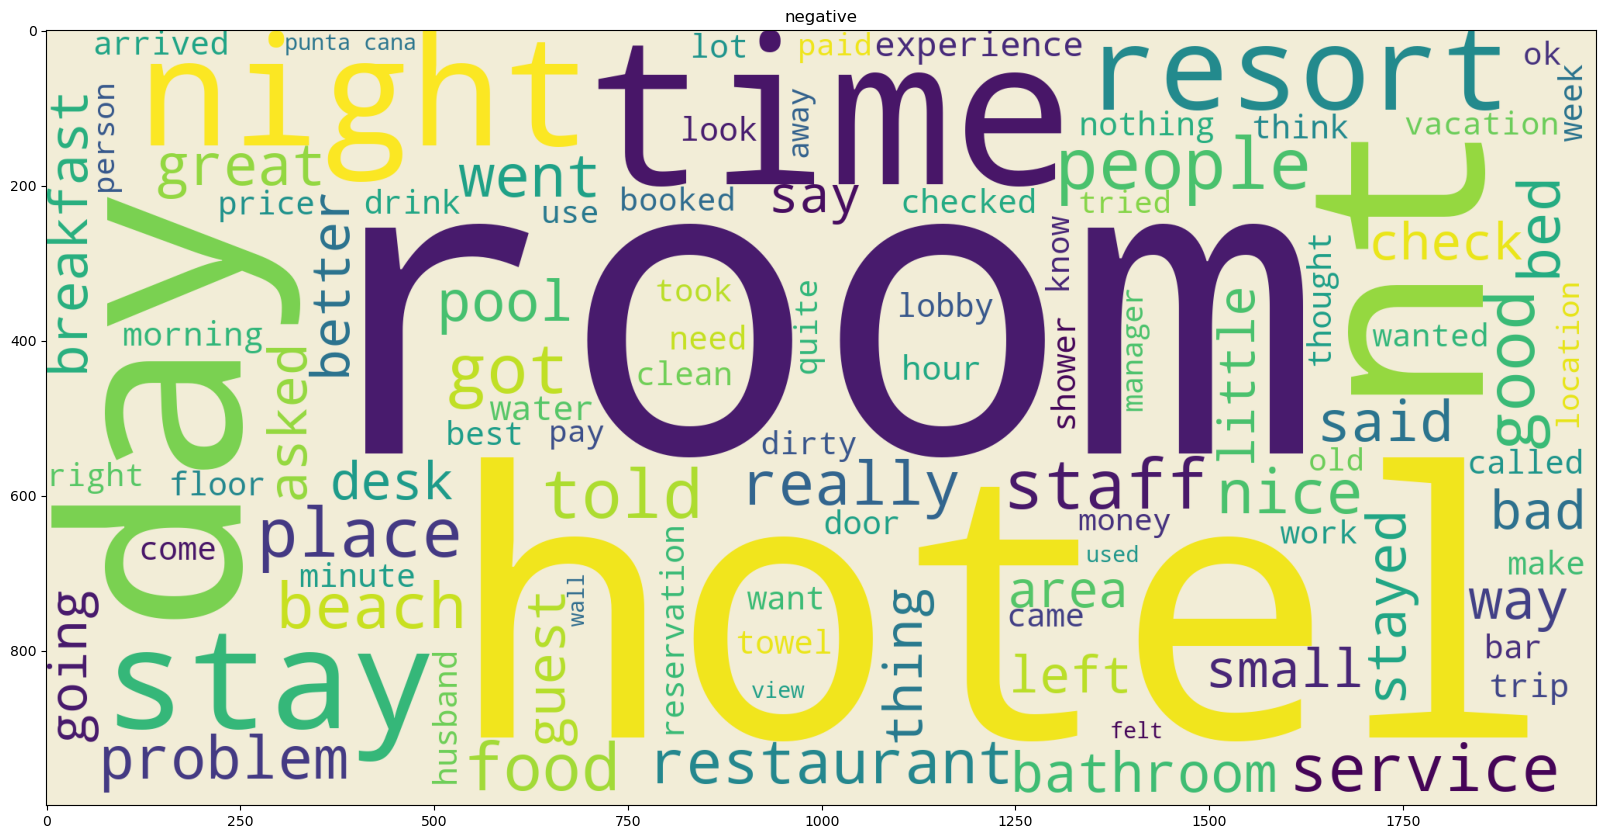

In [30]:
# Word cloud of positive, negative and neutral data

WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(negative_data)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

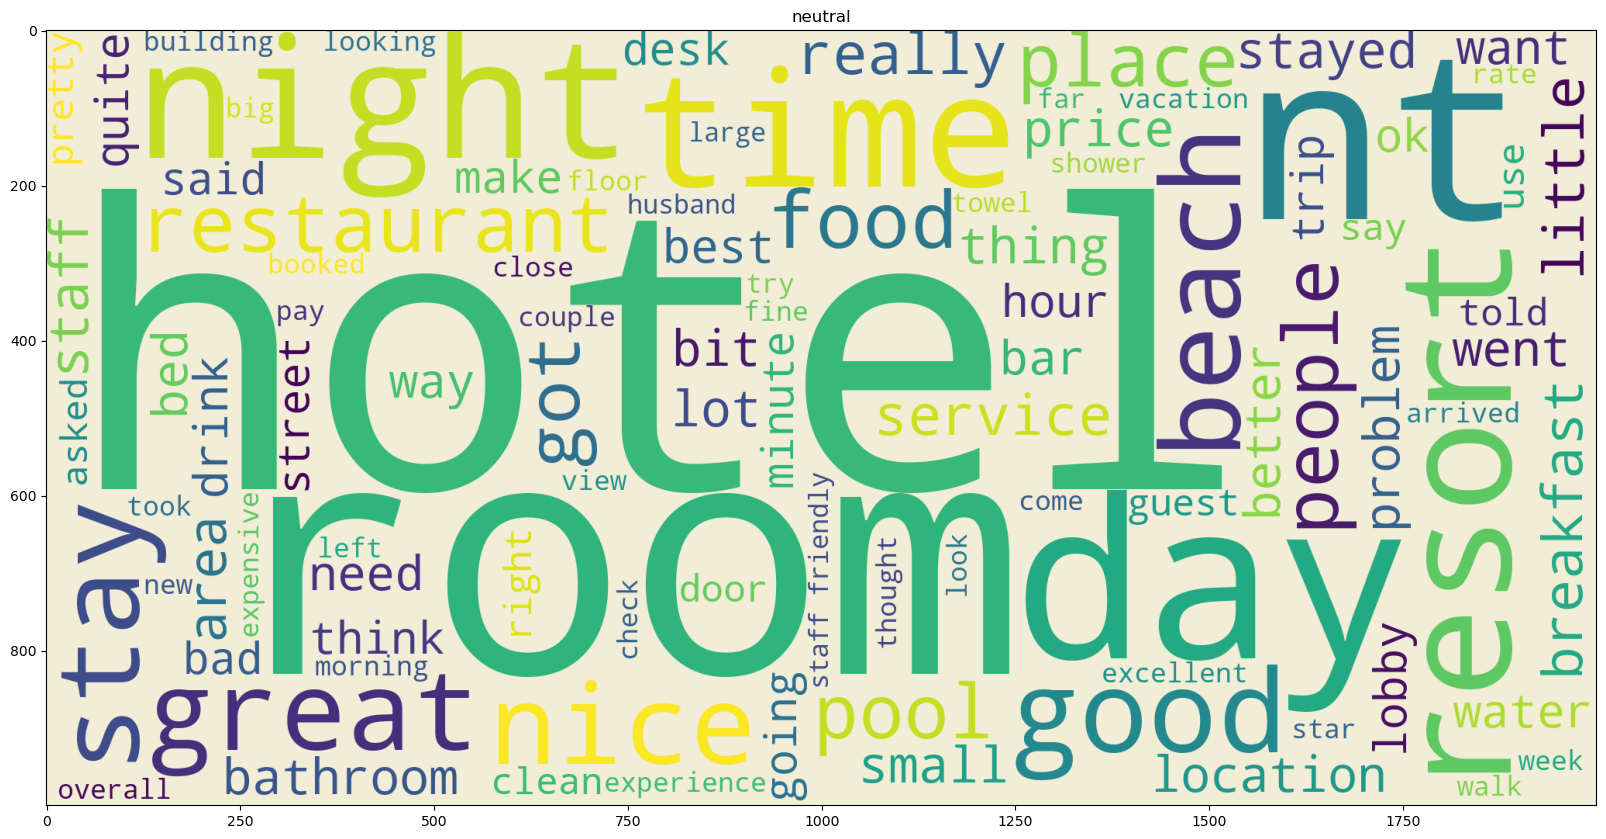

In [31]:
# Word cloud of positive, negative and neutral data

WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(neutral_data)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("neutral")
plt.show()

TFIDF for sentiment analysis


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df_oversampled['Review'])
y = df_oversampled['label']

Logistic Regression 

In [42]:
from sklearn.model_selection import train_test_split,GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y)


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)# -1 indicates using all available cores of cpu to run the model parelelly
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']  # 'liblinear' is a good choice for l1 and l2
}
grid_search = GridSearchCV(estimator=lr,
                           param_grid=param_grid,
                           cv=3,  # Using 3-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_lr = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_lr.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)


C:\Users\Affan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [45]:
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
score_lr = accuracy_score(y_test, y_pred)
score_lr


0.960583550826474

In [46]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4981
           1       0.93      0.99      0.96      4981
           2       0.99      0.90      0.94      4981

    accuracy                           0.96     14943
   macro avg       0.96      0.96      0.96     14943
weighted avg       0.96      0.96      0.96     14943



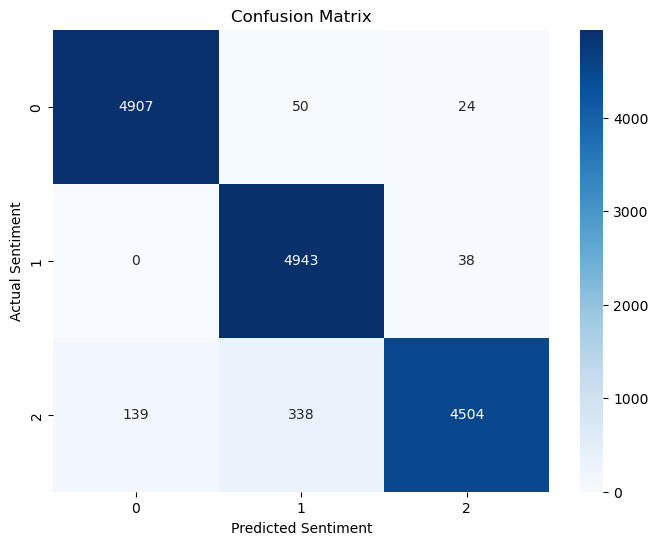

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_lr.classes_, yticklabels=best_lr.classes_)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()


As we can see in above confusion matrix all reviews(positive, negative and neutral) performed extremely well

out of 15000 Positive reviews Only 139 Positive reviews are wrongly classified as negative and 338 positive reviews were predicated as neutral revies

The rest misclassified sentimemts are below 50 which is Great
